# Google Colab-specific Setup

In [1]:
!pip install pyswarms==1.1.0

In [0]:
import gdown
from zipfile import ZipFile
gdown.download('https://drive.google.com/uc?export=download&id=11C8lWqT1Bqva_2NYkoGMqvX5ZF5SVJ4k', 'sls_data.zip', quiet=True)

with ZipFile('sls_data.zip', 'r') as zipObj:
   zipObj.extractall()

# Setup and Configuration

In [0]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
# For first time install
#!pip install pyswarms

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from pathlib import Path

import pyswarms as ps

In [0]:
# Configurations
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

NUM_MEALS = 21 # Assume 3 meals per day
NUM_FOOD = 70
MAX_CALORIES = 1800 * 7 # Weekly budget
SWARM_SIZE = 30
NUM_ITER = 1000

basepath = Path('.')
data = pd.read_csv(basepath/'food.csv')

food = data['Food']
cal_lookup = data['Calories'].values
utility = data['Utility'].values * -1 # reverse sign for minimization

In [7]:
data.head()

,Food,Calories,Utility,Carbohydrate,Fat,Protein,Category
0,Murtabak,674,60,0.18,0.75,0.07,Others
1,Ee Mee Seafood (Fried),1010,90,0.31,0.54,0.15,Noodle
2,Nasi Goreng Sayur,920,50,0.67,0.27,0.06,Rice
3,Claypot Rice,896,80,0.41,0.37,0.21,Rice
4,Ban Mian,476,50,0.41,0.42,0.18,Others


# PSO Modeling

In [0]:
# Define objective function - minimization
def f_per_particle(m, max_cal):
    """Computes for the objective function per particle
    
    Inputs
    ------
    m : numpy.ndarray
        Binary mask that can be obtained from BinaryPSO, will
        be used to indicate selected meals
    max_cal: int (default is defined as MAX_CALORIES)
        Constraint for weekly calorie budget
    
    Returns
    -------
    numpy.ndarray
        objective cost (utility)
    """
    j = 0
    # Penalty if solution not equal to NUM_MEALS
    if np.count_nonzero(m) != NUM_MEALS:
        j += 5e4
    
    j += utility[np.where(m==1)].sum() # utility is -ve
    cal_budget = cal_lookup[np.where(m==1)].sum()
    if cal_budget > max_cal:
        j += cal_budget # Penalty if over-budget
    
    return j

In [0]:
def f(x, max_cal=MAX_CALORIES):
    """Higher-level method to do cost search in the 
    whole swarm.
    
    Inputs
    ------
    x: numpy.ndarray of shape (n_particles, dimensions)
        The swarm that will perform the search
        
    Returns
    -------
    numpy.ndarray of shape (n_particles, )
        The computed loss for each particle
    """
    n_particles = x.shape[0]
    j = [f_per_particle(x[i], max_cal) for i in range(n_particles)]
    return np.array(j)
    

In [0]:
def run_model(options):
    """Runs model
    
    Inputs
    ------
    options: model options
        
    Returns
    -------
    cost
        final cost obtained
    pos
        final selection
    cost_history
        list of history of optimization costs
    """
    # Call instance of PSO
    optimizer = ps.discrete.BinaryPSO(n_particles=SWARM_SIZE, 
                                      dimensions=NUM_FOOD, options=options)

    # Perform optimization
    cost, pos = optimizer.optimize(f, iters=NUM_ITER)

    print(f'No. of food items selected: {pos.sum()}; '
          f'Avg calorie/day: {cal_lookup[np.where(pos==1)].sum()/7}')

    print('\nModel Run times:')
    return cost, pos, optimizer.cost_history

In [0]:
def plot_history(history):
    """Plots history
    
    Inputs
    ------
    history: list of history from PSO optimizer
        
    Returns
    -------
    None
    """
    
    plt.style.use('ggplot')     # if want to use the default style, set 'classic'
    plt.rcParams['ytick.right']     = True
    plt.rcParams['ytick.labelright']= True
    plt.rcParams['ytick.left']      = False
    plt.rcParams['ytick.labelleft'] = False
    plt.rcParams['font.family']     = 'Arial'
    
    plt.ylim([min(history)-1000,max(history)+500])
    plt.title('Cost History')
    plt.plot(history)

In [0]:
# ensure reproducibility
checkpoint_state = np.random.get_state()

## Initial Model

In [13]:
%%time
np.random.set_state(checkpoint_state)
options = {'c1': 0.5, 'c2': 0.5, 'w':0.9, 'k': SWARM_SIZE, 'p':2}
cost, pos, history = run_model(options)

2019-11-17 06:58:12,537 - pyswarms.discrete.binary - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary: 100%|██████████|1000/1000, best_cost=-1500.0
2019-11-17 06:58:18,482 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: -1500.0, best pos: [0 0 1 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 1 0 1 1 0 0
 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 1 0 0 0 1 0 0 0 0]


No. of food items selected: 21; Avg calorie/day: 1780.0

Model Run times:
CPU times: user 4.13 s, sys: 647 ms, total: 4.78 s
Wall time: 5.96 s


2019-11-17 06:58:18,569 - matplotlib.font_manager - WARNING - findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
2019-11-17 06:58:18,596 - matplotlib.font_manager - WARNING - findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


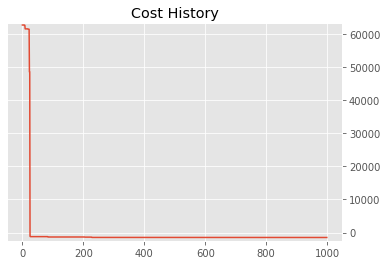

In [14]:
plot_history(history)

## Final Model

In [15]:
%%time
np.random.set_state(checkpoint_state)
options = {'c1': 1, 'c2': 2, 'w':0.9, 'k': SWARM_SIZE, 'p':1}
cost, pos, history = run_model(options)

2019-11-17 06:58:18,789 - pyswarms.discrete.binary - INFO - Optimize for 1000 iters with {'c1': 1, 'c2': 2, 'w': 0.9, 'k': 30, 'p': 1}
pyswarms.discrete.binary: 100%|██████████|1000/1000, best_cost=-1740.0
2019-11-17 06:58:24,648 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: -1740.0, best pos: [0 1 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 1 1 0 1 0 1 0 0 1 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0]


No. of food items selected: 21; Avg calorie/day: 1779.142857142857

Model Run times:
CPU times: user 4.07 s, sys: 545 ms, total: 4.61 s
Wall time: 5.88 s


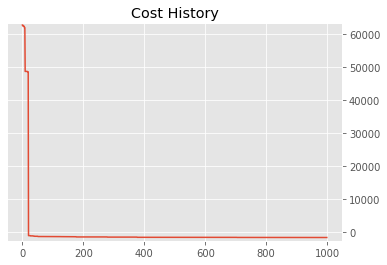

In [16]:
plot_history(history)

# Recommended Menu for the week

In [0]:
selected_food = food.values[np.where(pos==1)].tolist()

In [18]:
print('Recommended Menu for the week:\n')
for i, item in enumerate(selected_food):
    print(item,  end=', '), 
    if i % 3 == 2: 
        print("\n")

Recommended Menu for the week:

Ee Mee Seafood (Fried), Ngoh Hiang Mixed Items, Laksa, 

Ipoh Horfun, Chicken Teriyaki Don, Fried Hokkien Noodles, 

Braised Duck With Yam Rice, Lor Mee, Roti Prata with Egg (2 pieces), 

Mee Rebus, Nasi Lemak, Pork Satay with Sauce (10 sticks), 

Pork Porridge, Tau Suan, Pizza (2 slices), 

Carbonara, Butter Crab (500 gram), Mac and Cheese, 

Fish and Chips, Alfredo Pasta, Roti Prata Plain (2 pieces), 



## Generate Sample Menu for Workout Plan

In [0]:
selected_cal = cal_lookup[np.where(pos==1)].tolist()

In [20]:
tmp_food = []
tmp_cal = []
menu = {}
count = 0
p = np.random.permutation(len(selected_food))
for item, cal in zip(np.array(selected_food)[p], np.array(selected_cal)[p]):
    tmp_food.append(item)
    tmp_cal.append(cal)
    count += 1
    if count == 3: 
        day_food = ' | '.join(tmp_food)
        day_cal = sum(tmp_cal)
        print(day_food + ' cal: ' + str(day_cal))
        menu[day_food] = day_cal
        tmp_food = []
        tmp_cal = []
        count = 0

Ipoh Horfun | Ee Mee Seafood (Fried) | Butter Crab (500 gram) cal: 2135
Braised Duck With Yam Rice | Lor Mee | Chicken Teriyaki Don cal: 1579
Pork Satay with Sauce (10 sticks) | Fried Hokkien Noodles | Pizza (2 slices) cal: 1877
Laksa | Tau Suan | Pork Porridge cal: 1257
Ngoh Hiang Mixed Items | Alfredo Pasta | Roti Prata with Egg (2 pieces) cal: 1951
Carbonara | Roti Prata Plain (2 pieces) | Mac and Cheese cal: 1580
Mee Rebus | Nasi Lemak | Fish and Chips cal: 2075


In [21]:
menu_df = pd.DataFrame(list(menu.items()), columns= ['recommended_food', 'calories'])
menu_df.to_csv('sample_menu.csv', index=False)
menu_df

,recommended_food,calories
0,Ipoh Horfun | Ee Mee Seafood (Fried) | Butter ...,2135
1,Braised Duck With Yam Rice | Lor Mee | Chicken...,1579
2,Pork Satay with Sauce (10 sticks) | Fried Hokk...,1877
3,Laksa | Tau Suan | Pork Porridge,1257
4,Ngoh Hiang Mixed Items | Alfredo Pasta | Roti ...,1951
5,Carbonara | Roti Prata Plain (2 pieces) | Mac ...,1580
6,Mee Rebus | Nasi Lemak | Fish and Chips,2075
